In [1]:
import os
import warnings

import pandas as pd

from covid_model_deaths.data import get_input_data, plot_crude_rates
from covid_model_deaths import runner

pd.options.display.max_rows = 99
pd.options.display.max_columns = 99
warnings.simplefilter('ignore')

RUN_TYPE = 'dev'
DATESTAMP_LABEL = '2020_04_18_US'
DATA_VERSION = 'best'
PEAK_FILE = '/ihme/covid-19/deaths/mobility_inputs/2020_04_14/final_peak_locs_04_14.csv'
CASES_DEATHS_FILE = '/ihme/covid-19/deaths/mobility_inputs/2020_04_18/deaths_from_cases.csv'
PEAK_DURATION_FILE = '/ihme/covid-19/deaths/mobility_inputs/2020_04_14/smooth_peak_duration.csv'
R0_FILE = '/ihme/covid-19/deaths/mobility_inputs/2020_04_14/R0_dates.csv'


# # read in cov input file (predicted date of R0 == 1) to see if we are using these for a given location
# cov_df = pd.read_csv(R0_FILE)
# r0_locs = cov_df['location_id'].unique().tolist()
# del cov_df
r0_locs = []

# # less conservative peak ranges
# peak_dur_df = pd.read_csv(PEAK_DURATION_FILE)
# peak_dur_df = peak_dur_df.loc[peak_dur_df['Location'] != 'Colorado']
# peak_dur_df['peak start date'] = pd.to_datetime(peak_dur_df['peak start date'])
# peak_dur_df['peak end date'] = pd.to_datetime(peak_dur_df['peak end date'])


CODE_DIR = os.path.abspath('../src/covid_model_deaths')
OUTPUT_DIR = f'/ihme/homes/collijk/test_deaths_model'
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
checkpoint = runner.Checkpoint(OUTPUT_DIR)


print(f'Writing to {OUTPUT_DIR}')
print(CODE_DIR)
print(checkpoint)

def filter_data(data: pd.DataFrame) -> pd.DataFrame:
    # drop Georgia the country until we fix location_ids
    data = data[data['Country/Region'] != 'Georgia'].reset_index(drop=True)

    return data

Writing to /ihme/homes/collijk/test_deaths_model
/ihme/homes/collijk/code/covid/covid-model-deaths/src/covid_model_deaths
Checkpoint(/ihme/homes/collijk/test_deaths_model/checkpoint)


In [2]:
# Store pops for Bobby.
get_input_data('us_pops').to_csv(f'{OUTPUT_DIR}/pops.csv', index=False)

## read full (unrestricted) set from snapshot

In [3]:
# come up with more informative names...
input_full_df = filter_data(get_input_data('full_data', DATA_VERSION))
input_death_df = filter_data(get_input_data('deaths', DATA_VERSION))
input_age_pop_df = get_input_data('age_pop', DATA_VERSION)
input_age_death_df = get_input_data('age_death', DATA_VERSION)



checkpoint.write('full_data', input_full_df)
checkpoint.write('deaths', input_death_df)
checkpoint.write('age_pop', input_age_pop_df)
checkpoint.write('age_death', input_age_death_df)

2020-04-19 21:19:18.744 | INFO     | covid_model_deaths.runner:load:47 - Loading deaths from in memory cache.


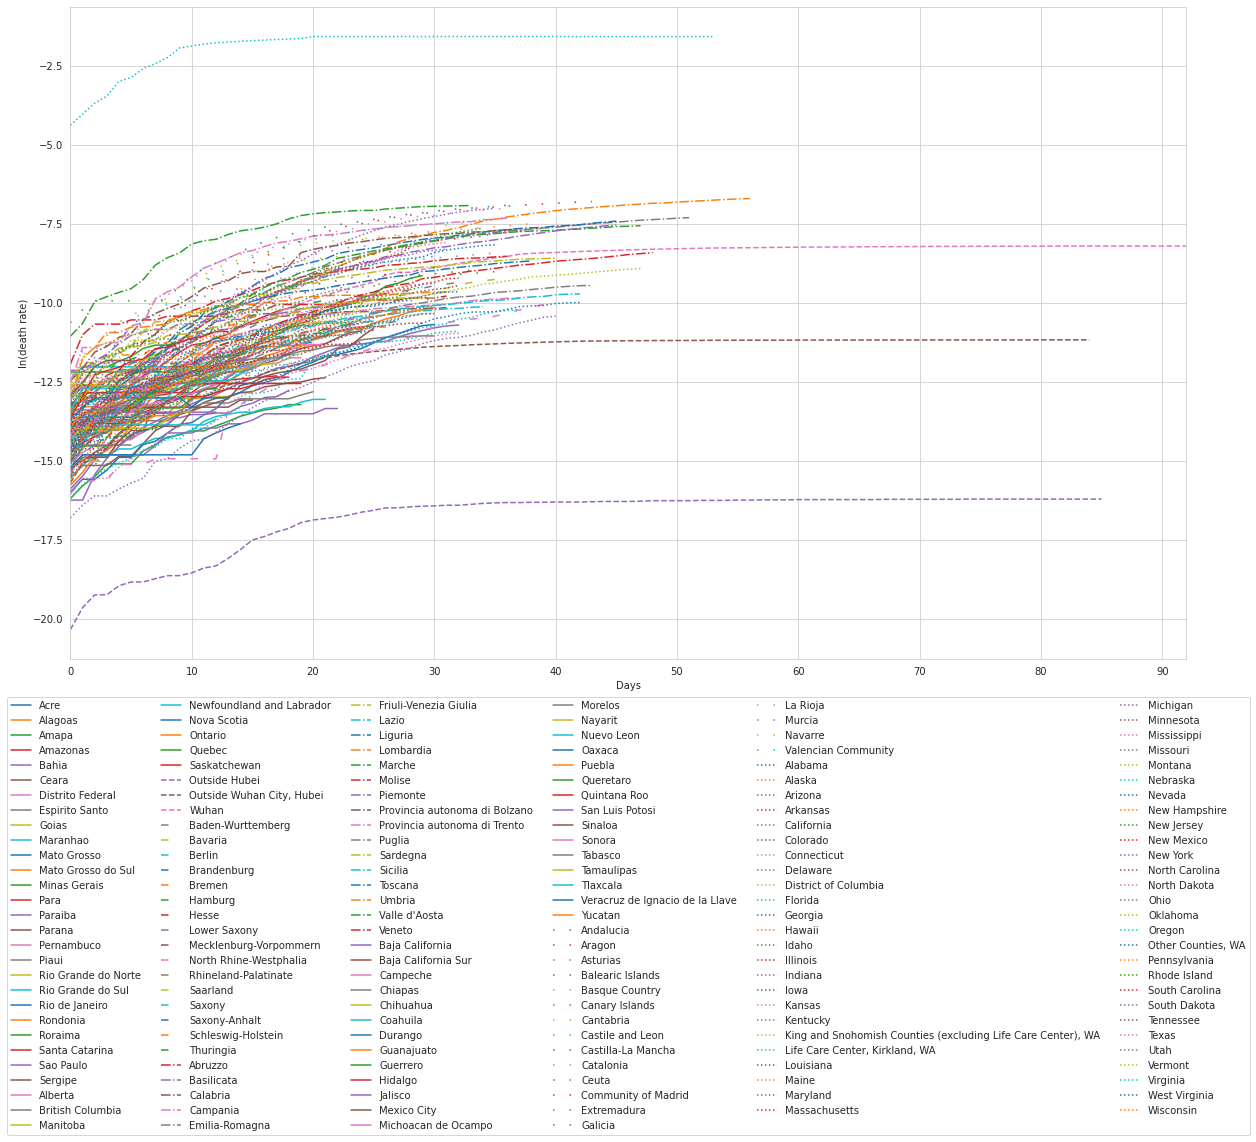

In [4]:
death_df = checkpoint.load('deaths')

# plot
plot_crude_rates(death_df, level='subnat')


## combine back-casted death rates with cases for abie (using model dataset, i.e. admin1 and below)

In [5]:
%%time
full_df = checkpoint.load('full_data')
death_df = checkpoint.load('deaths')
age_pop_df = checkpoint.load('age_pop')
age_death_df = checkpoint.load('age_death')

cases_and_backcast_deaths_df = runner.make_cases_and_backcast_deaths(full_df, death_df, age_pop_df, age_death_df)

cases_and_backcast_deaths_df.to_csv(f'{OUTPUT_DIR}/backcast_for_case_to_death.csv', index=False)
checkpoint.write('cases_and_backcast_deaths', cases_and_backcast_deaths_df)

2020-04-19 21:19:20.584 | INFO     | covid_model_deaths.runner:load:47 - Loading full_data from in memory cache.
2020-04-19 21:19:20.586 | INFO     | covid_model_deaths.runner:load:47 - Loading deaths from in memory cache.
2020-04-19 21:19:20.586 | INFO     | covid_model_deaths.runner:load:47 - Loading age_pop from in memory cache.
2020-04-19 21:19:20.588 | INFO     | covid_model_deaths.runner:load:47 - Loading age_death from in memory cache.
100%|██████████| 178/178 [01:19<00:00,  2.23it/s]


CPU times: user 1.84 s, sys: 311 ms, total: 2.15 s
Wall time: 1min 20s


## Impute death thresholds.

In [6]:
%%time
cases_and_backcast_deaths_df = checkpoint.load('cases_and_backcast_deaths')

in_us = cases_and_backcast_deaths_df['Country/Region'] == 'United States of America'
state_level = ~cases_and_backcast_deaths_df['Province/State'].isnull()
us_states = cases_and_backcast_deaths_df.loc[in_us & state_level, 'location_id'].unique().tolist()

us_threshold_dates = runner.impute_death_threshold(cases_and_backcast_deaths_df,
                                                   location_list=us_states)
us_threshold_dates = cases_and_backcast_deaths_df.merge(us_threshold_dates)
us_threshold_dates.to_csv(f'{OUTPUT_DIR}/threshold_dates.csv', index=False)
checkpoint.write('threshold_dates', us_threshold_dates)


2020-04-19 21:20:41.014 | INFO     | covid_model_deaths.runner:load:47 - Loading cases_and_backcast_deaths from in memory cache.
100%|██████████| 54/54 [00:03<00:00, 16.19it/s]


CPU times: user 1.3 s, sys: 219 ms, total: 1.52 s
Wall time: 4.51 s


## Make last day data

In [7]:
full_df = checkpoint.load('full_data')
us_threshold_dates = checkpoint.load('threshold_dates')

us_date_mean_df = runner.make_date_mean_df(us_threshold_dates)
last_day_df = runner.make_last_day_df(full_df, us_date_mean_df)
last_day_df.to_csv(f'{OUTPUT_DIR}/last_day.csv', index=False)

checkpoint.write('date_mean', us_date_mean_df)
checkpoint.write('last_day', last_day_df)

2020-04-19 21:21:08.113 | INFO     | covid_model_deaths.runner:load:47 - Loading full_data from in memory cache.
2020-04-19 21:21:08.116 | INFO     | covid_model_deaths.runner:load:47 - Loading threshold_dates from in memory cache.


## Submit models

In [2]:
full_df = checkpoint.load('full_data')
death_df = checkpoint.load('deaths')
age_pop_df = checkpoint.load('age_pop')
age_death_df = checkpoint.load('age_death')
us_date_mean_df = checkpoint.load('date_mean')
last_day_df = checkpoint.load('last_day')

cases_deaths_df = pd.read_csv(CASES_DEATHS_FILE)
cases_deaths_df['Date'] = pd.to_datetime(cases_deaths_df['Date'])

us_location_ids, us_location_names = runner.get_us_location_ids_and_names(full_df)

submodel_dict = runner.submit_models(full_df, death_df, age_pop_df, age_death_df, us_date_mean_df, cases_deaths_df,
                                     us_location_ids, us_location_names, r0_locs,
                                     PEAK_FILE, OUTPUT_DIR, DATA_VERSION, R0_FILE, CODE_DIR)


checkpoint.write('submodel_dict', submodel_dict)

2020-04-19 22:59:10.015 | INFO     | covid_model_deaths.runner:load:49 - Reading full_data from checkpoint dir /ihme/homes/collijk/test_deaths_model/checkpoint.
2020-04-19 22:59:10.027 | INFO     | covid_model_deaths.runner:load:49 - Reading deaths from checkpoint dir /ihme/homes/collijk/test_deaths_model/checkpoint.
2020-04-19 22:59:10.033 | INFO     | covid_model_deaths.runner:load:49 - Reading age_pop from checkpoint dir /ihme/homes/collijk/test_deaths_model/checkpoint.
2020-04-19 22:59:10.037 | INFO     | covid_model_deaths.runner:load:49 - Reading age_death from checkpoint dir /ihme/homes/collijk/test_deaths_model/checkpoint.
2020-04-19 22:59:10.041 | INFO     | covid_model_deaths.runner:load:49 - Reading date_mean from checkpoint dir /ihme/homes/collijk/test_deaths_model/checkpoint.
2020-04-19 22:59:10.045 | INFO     | covid_model_deaths.runner:load:49 - Reading last_day from checkpoint dir /ihme/homes/collijk/test_deaths_model/checkpoint.


1 / 53 locations
qsub -N curve_model_523_google_21 -P proj_covid -q d.q -b y -l m_mem_free=8G -l fthread=3 -o /share/temp/sgeoutput/covid/output/ -e /share/temp/sgeoutput/covid/errors/ /share/code/collijk/miniconda3/envs/covid-deaths-2020-04-19_13-11-20/bin/python /ihme/homes/collijk/code/covid/covid-model-deaths/src/covid_model_deaths/model.py --model_location_id 523 --data_file "/ihme/homes/collijk/test_deaths_model/model_data_google_21/523.csv" --cov_file "/ihme/homes/collijk/test_deaths_model/model_data_google_21/523_covariate.csv" --peaked_file "/ihme/covid-19/deaths/mobility_inputs/2020_04_14/final_peak_locs_04_14.csv" --output_dir "/ihme/homes/collijk/test_deaths_model/model_data_google_21/523" --last_day_file "/ihme/homes/collijk/test_deaths_model/last_day.csv" --covariate_effect gamma --n_draws=333
Your job 39608283 ("curve_model_523_google_21") has been submitted

qsub -N curve_model_523_descartes_21 -P proj_covid -q d.q -b y -l m_mem_free=8G -l fthread=3 -o /share/temp/sgeou

## compile draws

In [3]:
full_df = checkpoint.load('full_data')
age_pop_df = checkpoint.load('age_pop')
us_threshold_dates = checkpoint.load('threshold_dates')
submodel_dict = checkpoint.load('submodel_dict')

us_location_ids, us_location_names = runner.get_us_location_ids_and_names(full_df)

in_us = full_df['Country/Region'] == 'United States of America'
state_level = ~full_df['Province/State'].isnull()
usa_obs_df = full_df[in_us & state_level]

draw_dfs, past_draw_dfs, models_used, days, ensemble_draws_dfs = runner.compile_draws(us_location_ids,
                                                                                      us_location_names,
                                                                                      submodel_dict,
                                                                                      usa_obs_df,
                                                                                      us_threshold_dates,
                                                                                      age_pop_df)

if 'location' not in models_used:
    raise ValueError('No location-specific draws used, must be using wrong tag')
draw_df = pd.concat(draw_dfs)
model_type_df = pd.DataFrame({'location': us_location_names,
                              'model_used': models_used})

# write
draw_df.to_csv(f'{OUTPUT_DIR}/state_data.csv', index=False)
model_type_df.to_csv(f'{OUTPUT_DIR}/state_models_used.csv', index=False)
ensemble_plot_path = runner.make_and_save_draw_plots(OUTPUT_DIR, us_location_ids, us_location_names,
                                                     ensemble_draws_dfs, days, models_used, age_pop_df)
print(ensemble_plot_path)
checkpoint.write('draw_data', draw_df)

2020-04-20 08:56:58.394 | INFO     | covid_model_deaths.runner:load:47 - Loading full_data from in memory cache.
2020-04-20 08:56:58.396 | INFO     | covid_model_deaths.runner:load:47 - Loading age_pop from in memory cache.
2020-04-20 08:56:58.401 | INFO     | covid_model_deaths.runner:load:49 - Reading threshold_dates from checkpoint dir /ihme/homes/collijk/test_deaths_model/checkpoint.
2020-04-20 08:56:58.406 | INFO     | covid_model_deaths.runner:load:47 - Loading submodel_dict from in memory cache.


    Waiting for /ihme/homes/collijk/test_deaths_model/model_data_google_21/60407/draws.pkl...
    Waiting for /ihme/homes/collijk/test_deaths_model/model_data_google_21/60407/draws.pkl...
    Waiting for /ihme/homes/collijk/test_deaths_model/model_data_google_21/60407/draws.pkl...
    Waiting for /ihme/homes/collijk/test_deaths_model/model_data_google_21/60407/draws.pkl...
    Waiting for /ihme/homes/collijk/test_deaths_model/model_data_google_21/60407/draws.pkl...
    Waiting for /ihme/homes/collijk/test_deaths_model/model_data_google_21/60407/draws.pkl...
    Waiting for /ihme/homes/collijk/test_deaths_model/model_data_google_21/60407/draws.pkl...
    Waiting for /ihme/homes/collijk/test_deaths_model/model_data_google_21/60407/draws.pkl...
    Waiting for /ihme/homes/collijk/test_deaths_model/model_data_google_21/60407/draws.pkl...
    Waiting for /ihme/homes/collijk/test_deaths_model/model_data_google_21/60407/draws.pkl...
    Waiting for /ihme/homes/collijk/test_deaths_model/model_

KeyboardInterrupt: 

## total US deaths in this run

In [ ]:
draw_df = checkpoint.load('draw_data')

runner.display_total_deaths(draw_df)

## combine with previous predictions

In [ ]:
# ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ##
# raw_draw_path = f'{OUTPUT_DIR}/state_data.csv'
# average_draw_path = f'{OUTPUT_DIR}/past_avg_state_data.csv'
# yesterday_draw_path = '/ihme/covid-19/deaths/prod/2020_04_10_US/state_data.csv'
# before_yesterday_draw_path = '/ihme/covid-19/deaths/prod/2020_04_09_US/state_data.csv'
# ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ##

# avg_draw_df = runner.average_draws(OUTPUT_DIR, 'US', raw_draw_path, yesterday_draw_path, before_yesterday_draw_path)

# ## NO NEED TO DO THIS, FOR NOW ##
# # avg_df = get_peak_date(past_draw_df, avg_df)

# # store data
# avg_df.to_csv(average_draw_path, index=False)
# print(average_draw_path)

# # plot
# compare_average_plot_path = runner.make_and_save_compare_average_plots(OUTPUT_DIR,
#                                                                        raw_draw_path,
#                                                                        average_draw_path,
#                                                                        yesterday_draw_path,
#                                                                        before_yesterday_draw_path,
#                                                                        'United States of America')
# print(compare_average_plot_path)


In [ ]:
raw_draw_path = f'{OUTPUT_DIR}/state_data.csv'
previous_draw_path = '/ihme/covid-19/deaths/prod/2020_04_16_US/state_data.csv'

compare_to_previous_plot_path = runner.make_and_save_compare_to_previous_plots(OUTPUT_DIR, raw_draw_path, previous_draw_path)


In [ ]:

viz_dir = runner.send_plots_to_diagnostics(DATESTAMP_LABEL,
                                           ensemble_plot_path,
                                           # compare_average_plot_path,
                                           compare_to_previous_plot_path)
print(viz_dir)

